(rasterio2)=
# Raster-vector interactions

In [1]:
!echo Last updated: `date +"%Y-%m-%d %H:%M:%S"`

Last updated: 2023-07-20 14:15:33


In [2]:
import options

*****

## Introduction

So far, we have seen operations that involve the raster on its own, such as examining and transforming raster values through raster algebra (see {ref}`rasterio1`). Another set of common raster operation combines rasters with vector layers. For example, we may need to *crop* a raster according to a given polygon, or to *extract* raster values according to a point, line, or polygon layer. 

In this chapter, we explore operations that involve both a vector layer *and* a raster. This category includes operations such as:

* *Extracting* raster values according to a vector layer, either to polygons (see {ref}`zonal-statistics`) or to points (see {ref}`extracting-to-points`)
* *Masking* raster values according to polygons (see {ref}`rasterio-masking`)
* Raster-vector *transformations*, such as "raster to polygons" (see {ref}`raster-to-polygons`)

For accessing rasters and vector layers, we are going to use the `rasterio` and `geopandas` packages, which we are familiar with from the previous chapters (see {ref}`rasterio1` and {ref}`geopandas1`, respectively). Since the `rasterio` package is not natively compatible with `geopandas` data structures, however, we will have to resort to further transformations to combine them:

* For raster value extraction to polygons, we are going to use a helper third-party package called `rasterstats`, which works with both `rasterio` and `geopandas` and thus "bridges the gap" between them (see {ref}`zonal-statistics`).
* For all other operations, we are going to have to transform the vector layer data to suitable, simpler, formats, which the `rasterio` functions can accept, such as `shapely` geometries (see {ref}`rasterio-masking`). Conversely, we are going to transform `rasterio` vector outputs from `shapely` geometries to `geopandas` structures (see {ref}`raster-to-polygons`).

(rasterio2-sample-data)=
## Sample data

### Overview

First, let us load the packages we are going to work with in this chapter. There are two new packages which we have not worked with before:

* `rasterstats`—A package used for extracting raster data to points and polygons (see {ref}`zonal-statistics` and {ref}`extract-to-points-rasterstats`, respectively)
* `rasterio.mask`—A sub-package of `rasterio` used for masking (see {ref}`rasterio-masking`)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterstats
import rasterio.mask

Next, we reproduce two of the sample datasets from previous chapters, which we will use in the examples:

* `stat`—The statistical areas layer (`'data/statisticalareas_demography2019.gdb'`) (see {ref}`statistical-areas-haifa`) 
* `src`+`r`—The DEM of the Carmel area (`'output/carmel.tif'`) (see {ref}`carmel-dem`)

(statistical-areas-haifa)=
### Statistical areas of Haifa

Here we import the statistical areas layer, and subset the columns we are interested in, which include the statistical area ID, town name, and the geometry:

In [4]:
stat = gpd.read_file('data/statisticalareas_demography2019.gdb')
stat = stat[['STAT11', 'SHEM_YISHUV', 'geometry']]
stat

STAT11   SHEM_YISHUV                            geometry
0        1.0        המעפיל  MULTIPOLYGON (((198790.704 6985...
1        1.0       משגב עם  MULTIPOLYGON (((251692.761 7948...
2        1.0        גאולים  MULTIPOLYGON (((194649.280 6901...
3        1.0    להבות הבשן  MULTIPOLYGON (((260535.621 7833...
4        1.0        מכמורת  MULTIPOLYGON (((188690.124 7018...
...      ...           ...                                 ...
3190     1.0   קריית נטפים  MULTIPOLYGON (((210706.963 6693...
3191     1.0          דולב  MULTIPOLYGON (((212744.459 6482...
3192     1.0        עתניאל  MULTIPOLYGON (((202798.088 5942...
3193     1.0          יצהר  MULTIPOLYGON (((222570.662 6750...
3194     1.0  מבואות יריחו  MULTIPOLYGON (((239670.270 6459...

[3195 rows x 3 columns]

We will subset just the statistical areas of Haifa, which are within the DEM extent:

In [5]:
sel = stat['SHEM_YISHUV'] == 'חיפה'
stat = stat[sel]
stat

STAT11 SHEM_YISHUV                            geometry
1051   324.0        חיפה  MULTIPOLYGON (((200673.820 7467...
1052   331.0        חיפה  MULTIPOLYGON (((200241.190 7468...
1053   332.0        חיפה  MULTIPOLYGON (((199973.050 7468...
1054   333.0        חיפה  MULTIPOLYGON (((199728.171 7471...
1055   334.0        חיפה  MULTIPOLYGON (((199482.971 7478...
...      ...         ...                                 ...
1906   621.0        חיפה  MULTIPOLYGON (((199863.500 7459...
1907   622.0        חיפה  MULTIPOLYGON (((200222.121 7455...
1908   623.0        חיפה  MULTIPOLYGON (((200406.880 7452...
1909   631.0        חיפה  MULTIPOLYGON (((200373.041 7458...
1910   632.0        חיפה  MULTIPOLYGON (((199805.311 7465...

[105 rows x 3 columns]

Let us plot the resulting layer to see that we are on the right track:

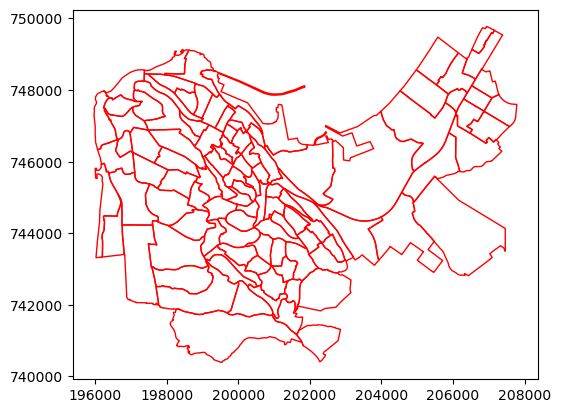

In [6]:
stat.plot(color='none', edgecolor='red');

(carmel-dem)=
### Digital Elevation Model

Next, we will import the DEM of the Haifa area, we created earlier (see {ref}`writing-rasters`), creating a file connection named `src`:

In [7]:
src = rasterio.open('output/carmel.tif')

and reading the values into an array named `r`. Recall that `r` is a two-dimensional array of type `int`, where the value `-9999` marks "No Data":

In [8]:
r = src.read(1)
r

array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

### Transforming to same CRS

Any spatial operation that involves two spatial layers requires that they are in the same CRS. Examining the CRS reveals that the `stat` layer is in ITM:

In [9]:
stat.crs

<Derived Projected CRS: EPSG:2039>
Name: Israel 1993 / Israeli TM Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Israel - onshore; Palestine Territory - onshore.
- bounds: (34.17, 29.45, 35.69, 33.28)
Coordinate Operation:
- name: Israeli TM
- method: Transverse Mercator
Datum: Israel 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

whereas the `dem` raster is in UTM:

In [10]:
src.crs

CRS.from_epsg(32636)

Therefore, we will transform the `stat` layer to the CRS of the raster (i.e., UTM), using the `.to_crs` method (see {ref}`reprojecting-with-to_crs`):

In [11]:
stat = stat.to_crs(src.crs)
stat

STAT11 SHEM_YISHUV                            geometry
1051   324.0        חיפה  MULTIPOLYGON (((687598.654 3632...
1052   331.0        חיפה  MULTIPOLYGON (((687164.328 3632...
1053   332.0        חיפה  MULTIPOLYGON (((686895.989 3632...
1054   333.0        חיפה  MULTIPOLYGON (((686645.312 3632...
1055   334.0        חיפה  MULTIPOLYGON (((686384.704 3633...
...      ...         ...                                 ...
1906   621.0        חיפה  MULTIPOLYGON (((686805.960 3631...
1907   622.0        חיפה  MULTIPOLYGON (((687171.572 3631...
1908   623.0        חיפה  MULTIPOLYGON (((687362.646 3631...
1909   631.0        חיפה  MULTIPOLYGON (((687317.320 3631...
1910   632.0        חיפה  MULTIPOLYGON (((686735.397 3632...

[105 rows x 3 columns]

In principle we could also [transform the raster](https://rasterio.readthedocs.io/en/latest/topics/reproject.html) to match the CRS of the vector layer, i.e., reproject the raster to ITM. However, raster reprojection involves resampling (to keep the raster *regular*), which inevitably distorts the distribution of raster values. Therefore, the general recommendation is to avoid raster reprojection as much as possible, preferring reprojection of the vector layer(s) to match the raster, and not vice versa.

Here is a plot of both the raster and vector layer (see {ref}`plotting-raster-and-vector-layer`), showing that they are indeed aligned:

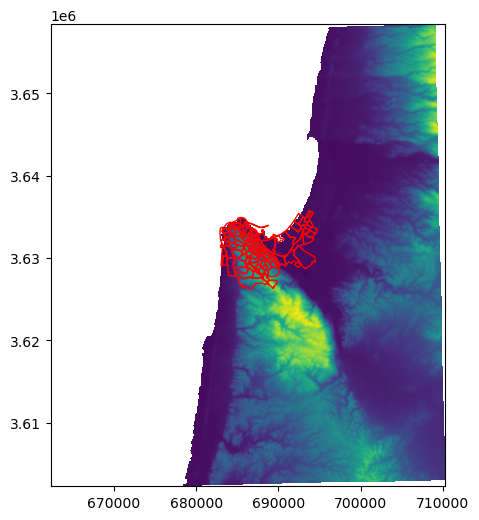

In [12]:
fig, ax = plt.subplots()
rasterio.plot.show(src, ax=ax)
stat.plot(ax=ax, edgecolor='red', color='none');

(zonal-statistics)=
## Zonal statistics

### Overview

In this section, we demonstrate extraction of raster values according to a polygonal layer, also known as *zonal statistics*. Extracting raster values according to a polygon layer involves summarizing, or aggregating, the raster values, because the polygons cover a (variable) number of raster pixels. Using a summary function, such as `'sum'` or `'mean'`, we obtain a single "summary" value per polygonal feature. 

The `rasterio` package is not natively integrated with `geopandas`, therefore to combine rasters and vector layers in the same operation we often need do one of the following:

* Process the vector layer with other methods that `rasterio` is compatible with (such as `shapely`)
* Use a third-party package that facilitates the raster-vector integration

As an example of the second approach, the operation of zonal statistics can be facilitated with the `rasterstats` package. The `rasterstats` works with `rasterio` rasters and `geopandas` vector layers. Given a raster and a vector layer, it can return a summary of pixel values, per feature, summarized withe user-specified functions.

In the example, we are going to calculate zonal statistics (mean, minimum, and maximum) of elevation (see {ref}`carmel-dem`) per statistical area of Haifa (see {ref}`statistical-areas-haifa`), which we created above. We will go through two steps:

* {ref}`calculating-zonal-statistics`—Actually calculating the zonal statistics, using the `rasterstast` package
* {ref}`zonal-merging-with-polygon-layer`—Attaching the statistics back to the polygonal layer of statistical areas (`stat`)

(calculating-zonal-statistics)=
### Calculating zonal statistics

To calculate zonal statistics, we use the [`rasterstats.zonal_stats`](https://pythonhosted.org/rasterstats/manual.html#zonal-statistics) function, from the `rasterstats` package which we loaded earlier (see {ref}`rasterio-loading-packages`). The `zonal_stats` function requires several inputs, as follows:

* The polygon layer that defines the areas where raster values are sampled. This can be a `GeoDataFrame` object, such as `stat`, or a `GeoSeries`.
* The array with raster data to be extracted. This needs to be a `ndarray` object, such as `r`.
* `nodata`—The array value which specifies "No Data" in the array, such as `-9999`.
* `affine`—The georeferencing matrix as defined in `rasterio`, such as `src.transform`.
* `stats`—a `list` of functions used to summarize raster values per polygon layer feature, such as `["mean","min","max"]`.

Other useful summary functions for the `stats` parameter of `zonal_stats` [include](https://pythonhosted.org/rasterstats/manual.html#statistics): 

* `"count"`—The number of valid (i.e., excluding "No Data") pixels
* `"nodata"`—The number of pixels with "No Data"
* `"majority"`—The most frequently occurring value
* `"median"`—The median value

Defining custom summary functions is also [possible](https://pythonhosted.org/rasterstats/manual.html#user-defined-statistics). Keep in mind that the calculation of the statistics ignores any "No Data" values.

Here is the `zonal_stats` function call in our case:

In [13]:
result = rasterstats.zonal_stats(
    stat, 
    r, 
    nodata = src.nodata, 
    affine = src.transform, 
    stats = ['mean', 'min', 'max']
)

The returned object, `result`, is a `list`:

In [14]:
type(result)

list

where each element is a `dict`, containing the summary statistics per feature. For example, `result[0]` contains the minimum, maximum, and mean elevation in the *first three* statistical areas:

In [15]:
result[:3]

[{'min': 5.0, 'max': 30.0, 'mean': 13.117647058823529},
 {'min': 15.0, 'max': 52.0, 'mean': 35.72727272727273},
 {'min': 41.0, 'max': 71.0, 'mean': 53.785714285714285}]

A list of dictionaries with repeated keys can be converted to a `DataFrame`, where the dictionaries comprise *rows*. This is a data structure we are more comfortable to work with, using the methods we learned so far. The conversion is done using the `pd.DataFrame` function:

In [16]:
result = pd.DataFrame(result)
result

min    max        mean
0      5.0   30.0   13.117647
1     15.0   52.0   35.727273
2     41.0   71.0   53.785714
3     10.0   64.0   33.300000
4      7.0   62.0   27.448980
..     ...    ...         ...
100  128.0  248.0  182.166667
101  113.0  209.0  160.360000
102  145.0  219.0  180.708333
103   87.0  135.0  106.545455
104   66.0  102.0   82.478261

[105 rows x 3 columns]

(zonal-merging-with-polygon-layer)=
### Merging with polygon layer

Our last step is to combine the zonal statistics `DataFrame` with the original vector layer, so that we have those values side-by-side with the geometries and any other attributes we have in the vector layer. This is basically a `pd.concat` operation of columns in a `GeoDataFrame` and columns in a `DataFrame`. However, we need to be careful with the index. As mentioned in {ref}`concatenation-by-column`, the indices of concatenated tables must match, since concatenation takes place *by index* rather than by position. Here, we have an example where indices indeed do not match, because the subsetting operation we made earlier (selecting "Haifa", see {ref}`statistical-areas-haifa`) modified the index:

In [17]:
result.index

RangeIndex(start=0, stop=105, step=1)

In [18]:
stat.index

Int64Index([1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060,
            ...
            1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910],
           dtype='int64', length=105)

To make the indices match, we can "reset" (see {ref}`resetting-the-index`) the indices of `stat` so that they are consecutive starting from zero, same as in `result`:

In [19]:
stat = stat.reset_index(drop=True)
stat

STAT11 SHEM_YISHUV                            geometry
0     324.0        חיפה  MULTIPOLYGON (((687598.654 3632...
1     331.0        חיפה  MULTIPOLYGON (((687164.328 3632...
2     332.0        חיפה  MULTIPOLYGON (((686895.989 3632...
3     333.0        חיפה  MULTIPOLYGON (((686645.312 3632...
4     334.0        חיפה  MULTIPOLYGON (((686384.704 3633...
..      ...         ...                                 ...
100   621.0        חיפה  MULTIPOLYGON (((686805.960 3631...
101   622.0        חיפה  MULTIPOLYGON (((687171.572 3631...
102   623.0        חיפה  MULTIPOLYGON (((687362.646 3631...
103   631.0        חיפה  MULTIPOLYGON (((687317.320 3631...
104   632.0        חיפה  MULTIPOLYGON (((686735.397 3632...

[105 rows x 3 columns]

In [20]:
stat.index

RangeIndex(start=0, stop=105, step=1)

Now we can safely use `pd.concat`:

In [21]:
stat = pd.concat([stat, result], axis=1)
stat

STAT11 SHEM_YISHUV                            geometry    min    max  \
0     324.0        חיפה  MULTIPOLYGON (((687598.654 3632...    5.0   30.0   
1     331.0        חיפה  MULTIPOLYGON (((687164.328 3632...   15.0   52.0   
2     332.0        חיפה  MULTIPOLYGON (((686895.989 3632...   41.0   71.0   
3     333.0        חיפה  MULTIPOLYGON (((686645.312 3632...   10.0   64.0   
4     334.0        חיפה  MULTIPOLYGON (((686384.704 3633...    7.0   62.0   
..      ...         ...                                 ...    ...    ...   
100   621.0        חיפה  MULTIPOLYGON (((686805.960 3631...  128.0  248.0   
101   622.0        חיפה  MULTIPOLYGON (((687171.572 3631...  113.0  209.0   
102   623.0        חיפה  MULTIPOLYGON (((687362.646 3631...  145.0  219.0   
103   631.0        חיפה  MULTIPOLYGON (((687317.320 3631...   87.0  135.0   
104   632.0        חיפה  MULTIPOLYGON (((686735.397 3632...   66.0  102.0   

           mean  
0     13.117647  
1     35.727273  
2     53.785714  
3     33.300000  
4     27.448980  
..          ...  
100  182.166667  
101  160.360000  
102  180.708333  
103  106.545455  
104   82.478261  

[105 rows x 6 columns]

Here is a visulization of the zonal statistics result. The colors reflect the average elevation within each statistical area:

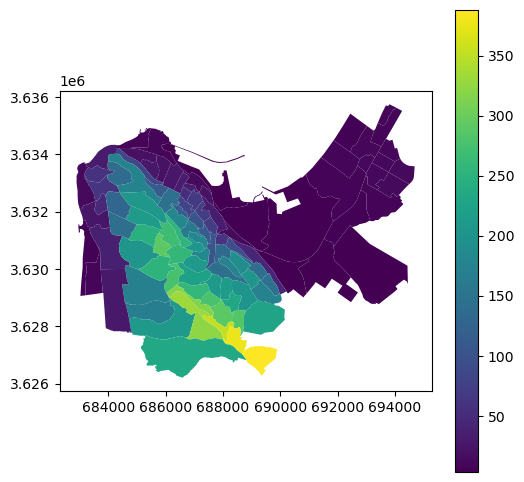

In [22]:
stat.plot(column='mean', legend=True);

(extracting-to-points)=
## Extracting to points

(extract-to-points-rasterstats)=
### Using `rasterstats`

The second commonly used variant of raster data extraction is extracting values to *points*. Extraction to points is conceptuially simpler than extracting to polygons (see {ref}`zonal-statistics`), because each point corresponds to just one raster value—the value of the pixel where the point falls in. Therefore, there is no need to summarize the extracted values. 

Before we begin, let us create a `GeoSeries` of type `"Point"` to demonstrate sampling of elevation values to points. For example, we can take a `GeoSeries` of statistical area centroids `pnt`:

In [23]:
pnt = stat.centroid
pnt

0      POINT (687071.047 3633050.615)
1      POINT (686881.442 3632830.238)
2      POINT (686685.459 3632620.552)
3      POINT (686547.304 3633006.256)
4      POINT (686252.055 3633228.654)
                    ...              
100    POINT (686408.245 3631777.877)
101    POINT (686856.572 3631373.063)
102    POINT (687138.866 3631048.022)
103    POINT (687078.293 3631697.326)
104    POINT (686700.041 3632186.932)
Length: 105, dtype: geometry

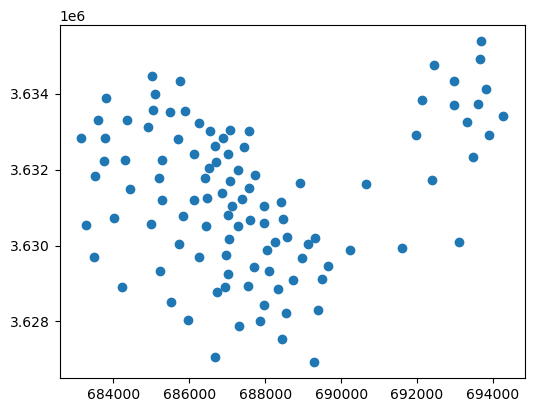

In [24]:
pnt.plot();

The `rasterstats` package has function called [`rasterstats.point_query`](https://pythonhosted.org/rasterstats/manual.html#basic-example), very similar in design to the `rasterstats.zonal_stats` function (see {ref}`calculating-zonal-statistics`). The principal difference is that we do not need to specify summary functions (`stats`), since each point corresponds to a single value and there is no need to "summarize" anything. Instead, there is an additional important argument `interpolate`, where we specify the type of interpolation:

* `'bilinear'`—Weighted average of four nearest pixels
* `'nearest'`—Value of the pixel that the point falls in

Typically we prefer to use `'nearest'` method, since it preserves the original raster values rather than averaging them.

For example, the following expression samples the elevation values from the Haifa DEM according to the statistical area centroids `pnt`:

In [25]:
result = rasterstats.point_query(
    pnt, 
    r, 
    nodata=src.nodata, 
    affine=src.transform,
    interpolate='nearest'
)

The result is a `list` of numeric elevations values:

In [26]:
result[:5]

[13, 42, 52, 33, 24]

We can "attach" it to the point geometries, as follows:

In [27]:
result = gpd.GeoDataFrame({'elev': result, 'geometry': pnt})
result

elev                        geometry
0      13  POINT (687071.047 3633050.615)
1      42  POINT (686881.442 3632830.238)
2      52  POINT (686685.459 3632620.552)
3      33  POINT (686547.304 3633006.256)
4      24  POINT (686252.055 3633228.654)
..    ...                             ...
100   159  POINT (686408.245 3631777.877)
101   150  POINT (686856.572 3631373.063)
102   196  POINT (687138.866 3631048.022)
103    99  POINT (687078.293 3631697.326)
104    84  POINT (686700.041 3632186.932)

[105 rows x 2 columns]

Here is a plot of the result:

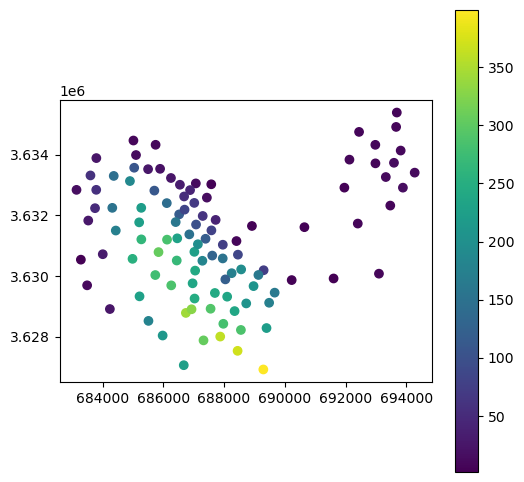

In [28]:
result.plot(column='elev', legend=True);

(extracting-to-points-using-rasterio)=
### Using `rasterio`

Sometimes, it is preferable (or essential) to reduce the number of dependencies on third-party packages. Therefore, to expand our capabilites and our understanding of the low-level `rasterio` functionality, we are now going to see how the last example can be reproduced without `rasterstats`, relying only on `geopandas` and `rasterio`. Another benefit is flexibility: the `rasterio` approach supports extraction from multi-band rasters, unlike `rasterstats` which only supports single-band rasters. 

To extract raster values to points, a `rasterio` raster file connection has a method called [`.sample`](https://geopandas.org/en/stable/gallery/geopandas_rasterio_sample.html#Sampling-the-data). The `.sample` method:

* accepts a `list` of coordinate pairs, such as `[(x,y),(x,y),...]`, and
* returns a `list` of raster value array (one per band), such as `[array([band1,band2,band3]),array([band1,band2,band3]),...]`

For example, suppose that we have a `list` with two `tuple`s representing two points in UTM:

In [29]:
x = [(687071.0468361621, 3633050.615206969), (686881.4418603638, 3632830.237625203)]
x

[(687071.0468361621, 3633050.615206969),
 (686881.4418603638, 3632830.237625203)]

Using `sample`, we can extract the raster values at those points:

In [30]:
src.sample(x)

<generator object sample_gen at 0x7fcc35c0c120>

 The result is a `generator` object, which we can iterate over:

In [31]:
for i in src.sample(x):
    print(i)

[13]
[42]


or obtain all values at once into a `list`:

In [32]:
list(src.sample(x))

[array([13], dtype=int16), array([42], dtype=int16)]

Inside the `list`, each element is an array (of length `1`, since the source raster has just one band):

In [33]:
list(src.sample(x))[0]

array([13], dtype=int16)

Indexing the array returns the pixel value:

In [34]:
list(src.sample(x))[0][0]

13

Knowing this, extracting raster values into a point `GeoDataFrame` is a matter of back and forth transformations, namely:

* extracting the `GeoDataFrame` coordinates into a `list` of tuples to be passed to `.sample`, and
* attaching the `list` of returned raster values back to a `GeoDataFrame` format

Let us begin. First, we use the `.to_list` method (see {ref}`pandas-to-list`) to go from a `GeoSeries` to a `list` of `shapely` geometries. For example, here are the first five geometries:

In [35]:
pnt.to_list()[:5]

[<POINT (687071.047 3633050.615)>,
 <POINT (686881.442 3632830.238)>,
 <POINT (686685.459 3632620.552)>,
 <POINT (686547.304 3633006.256)>,
 <POINT (686252.055 3633228.654)>]

Each element in the `list` is a `"Point"` geometry. We can access its coordinates using `.coords` along with a conversion to `list` (see {ref}`point-coordinates`). For example, here are the coordinates of the first point:

In [36]:
list(pnt.to_list()[0].coords)

[(687071.0468361623, 3633050.615206969)]

Adapting the above expression into *list comprehension* (see {ref}`list-comprehension`), we can extract all coordinate pairs into a plain `list` of tuples, as follows:

In [37]:
coords = [list(i.coords)[0] for i in pnt.to_list()]
coords[:5]

[(687071.0468361623, 3633050.615206969),
 (686881.441860364, 3632830.237625203),
 (686685.4586284278, 3632620.5516706416),
 (686547.3042551251, 3633006.256442973),
 (686252.0550834013, 3633228.6542930715)]

The list of coordinates (`coords`) can be passed to `.sample`. Then, we use another list comprehension to extract the values into a `list` called `values`:

In [38]:
values = [i[0] for i in src.sample(coords)]
values[:5]

[13, 42, 52, 33, 24]

Since we know that `values` is in agreement with `pnt`, we can safely bind them into a `GeoDataFrame`. We get then same result as using `rasterstats.point_query` (see {ref}`extract-to-points-rasterstats`):

In [39]:
result = gpd.GeoDataFrame({'elev': values, 'geometry': pnt})
result

elev                        geometry
0      13  POINT (687071.047 3633050.615)
1      42  POINT (686881.442 3632830.238)
2      52  POINT (686685.459 3632620.552)
3      33  POINT (686547.304 3633006.256)
4      24  POINT (686252.055 3633228.654)
..    ...                             ...
100   159  POINT (686408.245 3631777.877)
101   150  POINT (686856.572 3631373.063)
102   196  POINT (687138.866 3631048.022)
103    99  POINT (687078.293 3631697.326)
104    84  POINT (686700.041 3632186.932)

[105 rows x 2 columns]

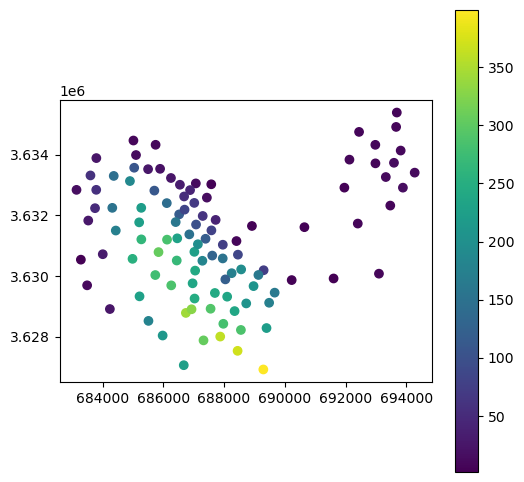

In [40]:
result.plot(column='elev', legend=True);

(rasterio-masking)=
## Masking

### Masking with `rasterio.mask.mask`

Masking a raster means "erasing" values outside an area of interest, defined using a polygon, by turning them into "No Data". In the following example, we are going to mask the DEM raster using the layer of statistical areas of Haifa `stat` (see {ref}`statistical-areas-haifa`).

The [`rasterio.mask.mask`](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html#masking-a-raster-using-a-shapefile) function can be used for masking. It accepts the following arguments:

* `dataset`—A raster file connection
* `shapes`—A list of `shapely` polygons
* `crop`—Whether to also reduce (i.e., crop) the raster extent according to the extent of `shapes`
* `nodata`—Value to use for "No Data". Typically:
    * a specific value (e.g., `-9999`) for `int` rasters, or 
    * `np.nan` for `float` rasters.

For example, here is how we can mask (and crop!) the DEM according to the `stat` polygon layer. The resulting raster has smaller extent, and the values which are outside of the statistical areas of Haifa are "erased":

In [41]:
out_image, out_transform = rasterio.mask.mask(
    src, 
    stat.geometry.to_list(), 
    crop=True, 
    nodata=-9999
)

Note that `rasterio.mask.mask` returns a `tuple`, which we immediately ["unpack"](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences) into two variables: `out_image` and `out_transform`.

In [42]:
# Tuple unpacking
a, b = (3, 12)

In [43]:
a

3

In [44]:
b

12

An alternative way to do the same, but without unpacking, could be:

In [45]:
result = rasterio.mask.mask(src, stat.geometry.to_list(), crop=True, nodata=-9999)
out_image = result[0]
out_transform = result[1]

Either way, the first variable, `out_shape`, contains the array of (cropped) raster values:

In [46]:
out_image

array([[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        ...,
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]]], dtype=int16)

The second variable, `out_transform`, contains the transformation matrix:

In [47]:
out_transform

Affine(90.0, 0.0, 682837.0,
       0.0, -90.0, 3635822.0)

Note that `out_image` is a three-dimensional array (with one "layer"). For simplicity, we can transform it "back" to a two-dimensional array, by subsetting the first and only band:

In [48]:
out_image = out_image[0]
out_image

array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

```{admonition} Exercise 11-c
:class: important
* Why do you think we a new transformation matrix is returned? (Can we use the original transformation matrix instead?)
```

Here is a visualization of the result:

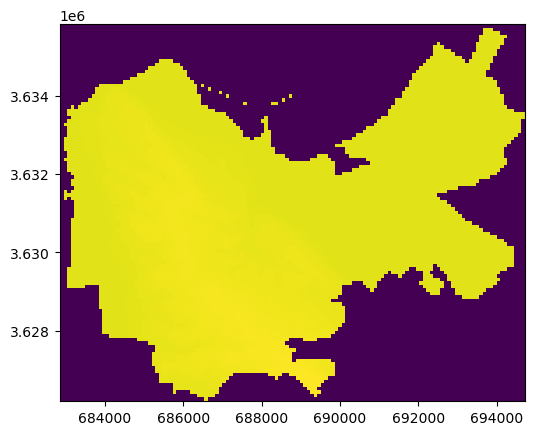

In [49]:
rasterio.plot.show(out_image, transform=out_transform);

The extreme value of "No Data" (`-9999`) obscures the variataion of valid pixels. One way to address this is to switch to `float` representation, where "No Data" values can be replaced with `np.nan` (see exercise below). Another way to address this is to write the raster to file, where the value of "No Data" is documented, and then reproduce the plot use a file connection (see {ref}`exporting-masked-raster`).

```{admonition} Exercise 11-c
:class: important
* Convert the above image to `float`, replace `"No Data"` values with `np.nan`, and plot the result ({numref}`exercise-11-c`).
```

```{glue:figure} exercise-11-c
---
name: exercise-11-c
---
Solution of exercise-11-c: Masked array of `carmel.tif` after conversion to float and replacing "No Data" with `np.nan`
```

```{admonition} Exercise 11-d
:class: important
* Repeat the last exercise, but this time use `crop=False` inside `rasterio.mask.mask` ({numref}`exercise-11-d`).
* Explain the difference between the two options, `crop=True` and `crop=False`.
```

```{glue:figure} exercise-11-d
---
name: exercise-11-d
---
Solution of exercise-11-d: Same as the last figure, but using `crop=False`
```

(exporting-masked-raster)=
### Exporting masked raster

To export the masked and cropped raster to file, we first need to update the metadata object according to the properties which have changed (see {ref}`writing-rasters`). In this case, through masking and cropping we changed the raster dimensions (`height`, `width`) and the transformation matrix (`transform`). Therefore:

In [50]:
meta = src.meta
meta.update(height=out_image.shape[0])
meta.update(width=out_image.shape[1])
meta.update(transform=out_transform)
meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 132,
 'height': 107,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(90.0, 0.0, 682837.0,
        0.0, -90.0, 3635822.0)}

Now we can write the `out_image` to file, which we name `carmel_cropped.tif`:

In [51]:
new_dataset = rasterio.open('output/carmel_cropped.tif', 'w', **meta)
new_dataset.write(out_image, 1)
new_dataset.close()

Let us try to read back the result and plot it, which has the advantage of showing "No Data" values in white color:

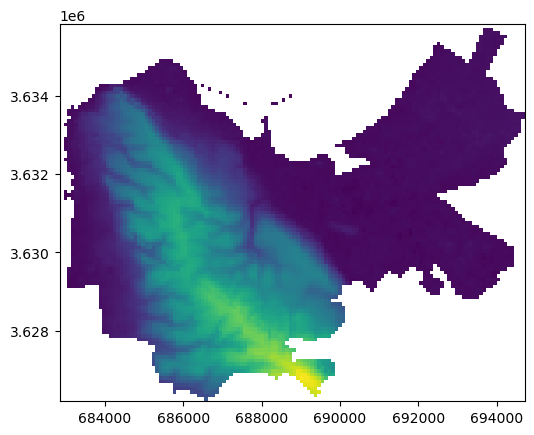

In [52]:
src_carmel_cropped = rasterio.open('output/carmel_cropped.tif')
rasterio.plot.show(src_carmel_cropped);

```{note}
For more details about masking with `rasterio`, see the dicumentation: <https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html>
```

(raster-to-polygons)=
## Raster to polygons

### Overview

The last raster-vector operation we are going to explore in this chapter is the conversion from raster to a vector layer. In general, there are three types of conversions:

* Raster to points
* Raster to polygons
* Raster to contours

The first two conversions are straightforward. Essentially, each raster pixel is transformed to a point, or to a polygon, resulting in a point or polygon layer, respectively. Additionally, in a *raster to polygons* conversion, adjacent pixels with identical values are typically dissolved into larger polygons. The *raster to contours* conversion is different, as the resulting layer does not represent pixel geometry directly, but through a contour algorithm, which is beyond the scope of `rasterio`. 

In this section, we demonstrate the *raster to polygons* conversion. We leave the *raster to points* conversion as an exercise for the reader ({numref}`exercise-11-f`). The *raster to contours* conversion is beyond the scope of this book.

(rasterio-features-shapes-function)=
### The `rasterio.features.shapes` function

The [`rasterio.features.shapes`](https://rasterio.readthedocs.io/en/latest/topics/features.html#extracting-shapes-of-raster-features) function gives access to the raster pixel geometries, as polygons, and their values. The returned object is an iterator (more specifically, a generator), which yields `geometry,value` pairs. We can use `mask` to filter the geometries. Furthermore, we must use `transform` to yield true spatial coordinates of the polygons.

For example, the following expression returns a generator named `shapes`, referring to all pixels with values greater than `525` in the `r` array (i.e., pixels with elevation above 525 $m$):

In [53]:
shapes = rasterio.features.shapes(r, mask=r>525, transform=src.transform)
shapes

<generator object shapes at 0x7fcc2ff2b4c0>

We can generate all shapes at once, into a `list` named `pol`, as follows:

In [54]:
pol = list(shapes)

Each element in `pol` is a `tuple` of length 2, containing:

* The GeoJSON-like `dict` representing the polygon geometry
* The value of the pixel(s) which comprise the polygon

For example:

In [55]:
pol[0]

({'type': 'Polygon',
  'coordinates': [[(690397.0, 3625022.0),
    (690397.0, 3624932.0),
    (690487.0, 3624932.0),
    (690487.0, 3625022.0),
    (690397.0, 3625022.0)]]},
 526.0)

The GeoJSON-like `dict`:

In [56]:
pol[0][0]

{'type': 'Polygon',
 'coordinates': [[(690397.0, 3625022.0),
   (690397.0, 3624932.0),
   (690487.0, 3624932.0),
   (690487.0, 3625022.0),
   (690397.0, 3625022.0)]]}

can be directly translated to a `shapely` geometry using `shapely.geometry.shape` ({ref}`shapely-from-dict`):

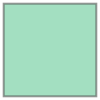

In [60]:
x = shapely.geometry.shape(pol[0][0])
x

The second element in the `tuple`, the pixel value, is a plain number:

In [61]:
pol[0][1]

526.0

### Raster to `GeoDataFrame`

Going from a `list` of geometries and associated values to a `GeoDataFrame` is something we already know how to do (see {ref}`list-comprehension`, {ref}`geoseries-from-scratch`, {ref}`creating-dataframe`, and {ref}`layer-from-scratch`). First, we extract just the geometries into a `list`, and transform it to a `GeoSeries`:

In [62]:
geom = [shapely.geometry.shape(i[0]) for i in pol]
geom = gpd.GeoSeries(geom, crs=src.crs)
geom

0     POLYGON ((690397.000 3625022.00...
1     POLYGON ((690487.000 3625022.00...
2     POLYGON ((690577.000 3624932.00...
3     POLYGON ((692017.000 3623852.00...
4     POLYGON ((692017.000 3623762.00...
                     ...                
40    POLYGON ((693007.000 3622502.00...
41    POLYGON ((693727.000 3622052.00...
42    POLYGON ((693817.000 3622052.00...
43    POLYGON ((693817.000 3621962.00...
44    POLYGON ((693907.000 3621962.00...
Length: 45, dtype: geometry

Then, we extract just the values into a `list`, and transform it to a `Series`:

In [63]:
values = [i[1] for i in pol]
values = pd.Series(values)
values

0     526.0
1     527.0
2     526.0
3     527.0
4     528.0
      ...  
40    527.0
41    529.0
42    527.0
43    528.0
44    529.0
Length: 45, dtype: float64

Finally, we combine the two—the `Series` and the `GeoSeries`—into a `GeoDataFrame`:

In [64]:
result = gpd.GeoDataFrame({'elev': values, 'geometry': geom})
result

elev                            geometry
0   526.0  POLYGON ((690397.000 3625022.00...
1   527.0  POLYGON ((690487.000 3625022.00...
2   526.0  POLYGON ((690577.000 3624932.00...
3   527.0  POLYGON ((692017.000 3623852.00...
4   528.0  POLYGON ((692017.000 3623762.00...
..    ...                                 ...
40  527.0  POLYGON ((693007.000 3622502.00...
41  529.0  POLYGON ((693727.000 3622052.00...
42  527.0  POLYGON ((693817.000 3622052.00...
43  528.0  POLYGON ((693817.000 3621962.00...
44  529.0  POLYGON ((693907.000 3621962.00...

[45 rows x 2 columns]

Here is a plot of the result, the DEM pixels that are above 525 $m$ as polygons:

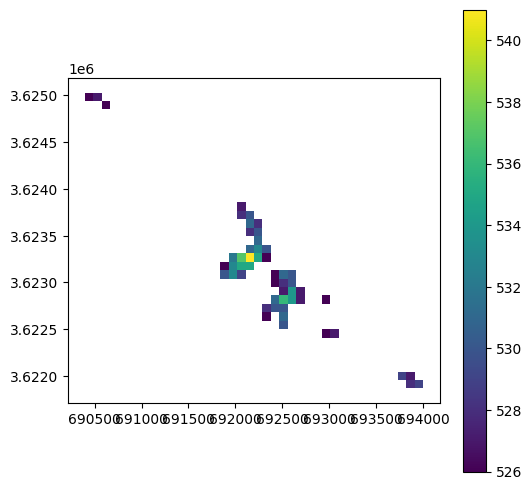

In [65]:
result.plot(column='elev', legend=True);

Plotting just the geometries, without symbology, reveals the dissoving of neighboring pixels where elevation is identical:

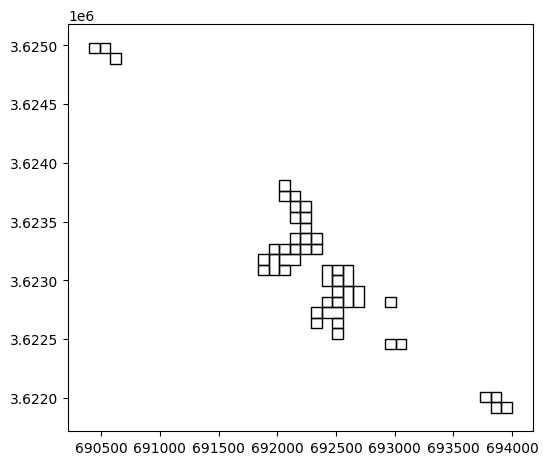

In [66]:
result.plot(color='none');

```{admonition} Exercise 11-e
:class: important
* Dissolve the above polygon layer into a single `'MultiPolygon'` geometry and plot it ({numref}`exercise-11-e`).
* What is the total area with alevation above 525 $m$? (answer: `421200.0`)
* How many separate `'Polygon'` geometries is the dissolved `'MultiPolygon'` composed of? (answer: `7`)
```

```{glue:figure} exercise-11-e
---
name: exercise-11-e
---
Solution of exercise-11-e: "Raster to polygons" result dissoved
```

```{admonition} Exercise 11-f
:class: important
* Create a point layer of the pixels with elevation above 525 $m$. The result should be a `GeoDataFrame` of type `'Point'`, with an attribute named `'elev'` reflecting the elevation of each point.
* Plot the result, with symbology according to `'elev'` ({numref}`exercise-11-f`)
* Hint: you can replace the `r` array values with sequential values (so that no pixels are dissolved), transform to polygons, then calculate the polygon centroids, and finally extract elevation values to those points.
```

```{glue:figure} exercise-11-f
---
name: exercise-11-f
---
Solution of exercise-11-f: "Raster to points" result
```

```{note}
The opposite transformation, i.e., from vector layer to raster, is known as *rasterizing*. Technically, rasterizing implies "burning" vector layer attribute values into a template raster, at those pixels covered by the vector layer. See the [*Burning shapes into a raster*](https://rasterio.readthedocs.io/en/latest/topics/features.html#burning-shapes-into-a-raster) entry in the `rasterio` documentation for details.
```

(exercise-rasterio2)=
## More exercises

```{admonition} Exercise 11-g
:class: important
* Calculate the proportion of land area that is above elevation of 100 $m$, for each statistical area of Haifa, according to the same polygon layer and DEM as in {ref}`zonal-statistics`.
* To do that, first classify the DEM to values to `0` (below 100 $m$ or "No Data") and `1` (above 100 $m$). Then, calculate the zonal average of the zeroes and ones per statistical area. The resulting values are going to be equal to the proportion of pixels (i.e., proportion of area) that is above 100 $m$.
* Show the results on a map ({numref}`exercise-11-g`).
```

```{glue:figure} exercise-11-g
---
name: exercise-11-g
---
Solution of exercise-11-g: Proportion of land area above 400 m in statistical areas of Haifa
```

```{admonition} Exercise 11-h
:class: important
* Calculate and plot the average spectral profile (in blue, green, red, and NIR) of `"Be'er Sheva"`, `"Lehavim"`, `"Omer"`, `"Lakiye"`, and `"Segev Shalom"`, according to the towns layer (`muni_il.shp`, names in the `"Muni_Eng"` column) and the multi-spectral Sentinel-2 image (`sentinel2.tif`) ({numref}`exercise-11-h`).
```

```{glue:figure} exercise-11-h
---
name: exercise-11-h
---
Solution of exercise-11-h: Spectral profiles of four towns
```

## Exercise solutions

In [67]:
from myst_nb import glue

### Exercise 11-c

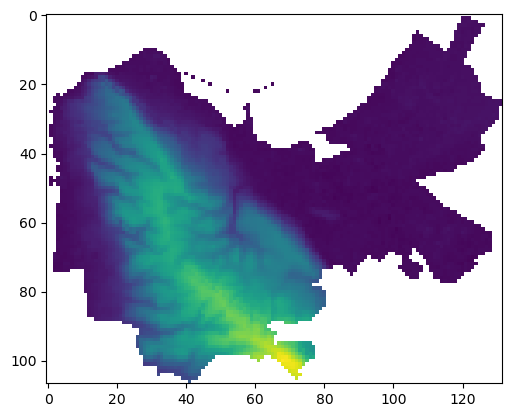

<AxesSubplot:>

In [2]:
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
# Prepare raster
src = rasterio.open('output/carmel.tif')
# Prepare polygons
stat = gpd.read_file('data/statisticalareas_demography2019.gdb')
stat = stat[['STAT11', 'SHEM_YISHUV', 'geometry']]
sel = stat['SHEM_YISHUV'] == 'חיפה'
stat = stat[sel]
stat = stat.to_crs(src.crs)
# Mask
out_image, out_transform = rasterio.mask.mask(src, stat.geometry.to_list(), crop=True, nodata=-9999)
out_image = out_image[0]
# To 'float'
out_image1 = out_image.astype(float)
out_image1[out_image1 == -9999] = np.nan
# Plot
rasterio.plot.show(out_image1);

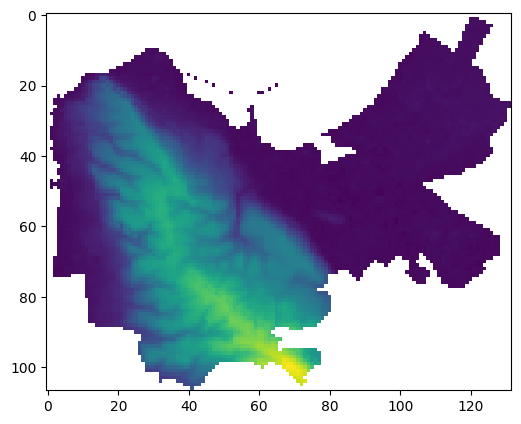

In [70]:
plot = rasterio.plot.show(out_image1)
fig = plot.get_figure()
glue("exercise-11-c", fig, display=False)

### Exercise 11-e

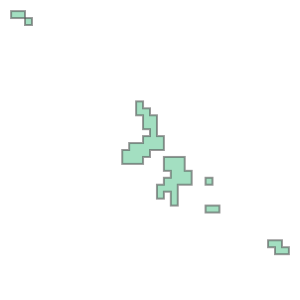

In [71]:
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.mask
from rasterio.plot import show
# Prepare raster
src = rasterio.open('output/carmel.tif')
r = src.read(1)
# Prepare polygons
stat = gpd.read_file('data/statisticalareas_demography2019.gdb')
stat = stat[['STAT11', 'SHEM_YISHUV', 'geometry']]
sel = stat['SHEM_YISHUV'] == 'חיפה'
stat = stat[sel]
stat = stat.to_crs(src.crs)
# Raster to polygons
shapes = rasterio.features.shapes(r, mask=r > 525, transform=src.transform)
pol = list(shapes)
geom = [shapely.geometry.shape(i[0]) for i in pol]
geom = gpd.GeoSeries(geom, crs=src.crs)
values = [i[1] for i in pol]
values = pd.DataFrame({'elev': values})
result = gpd.GeoDataFrame(data=values, geometry=geom)
# Dissolve
result = result.unary_union
result

In [72]:
result.area

421200.0

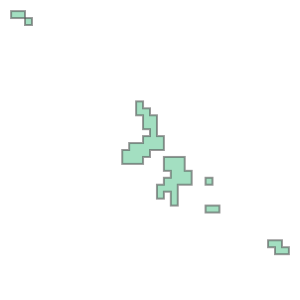

In [73]:
glue('exercise-11-e', result)

### Exercise 11-d

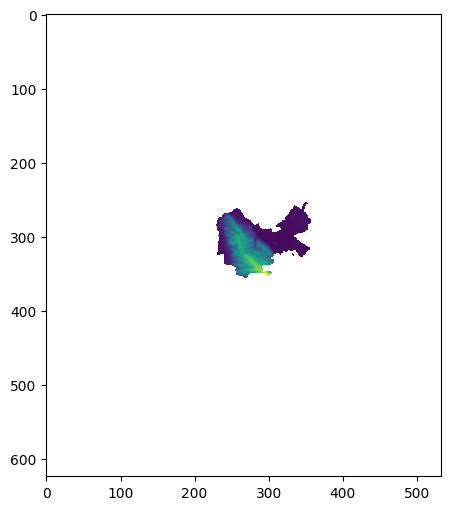

In [74]:
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
# Prepare raster
src = rasterio.open('output/carmel.tif')
# Prepare polygons
stat = gpd.read_file('data/statisticalareas_demography2019.gdb')
stat = stat[['STAT11', 'SHEM_YISHUV', 'geometry']]
sel = stat['SHEM_YISHUV'] == 'חיפה'
stat = stat[sel]
stat = stat.to_crs(src.crs)
# Mask
out_image, out_transform = rasterio.mask.mask(src, stat.geometry.to_list(), crop=False, nodata=-9999)
out_image = out_image[0]
# To 'float'
out_image1 = out_image.astype(float)
out_image1[out_image1 == -9999] = np.nan
# Plot
rasterio.plot.show(out_image1);

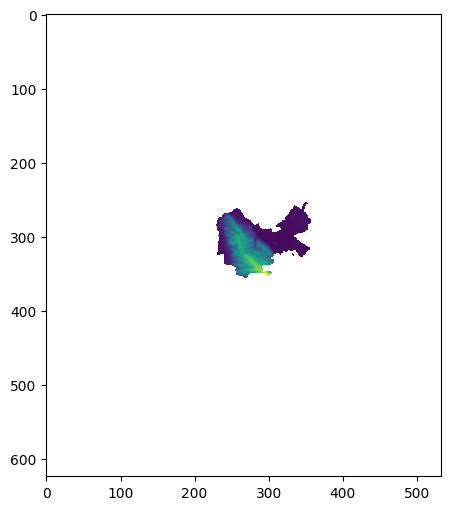

In [75]:
plot = rasterio.plot.show(out_image1)
fig = plot.get_figure()
glue("exercise-11-d", fig, display=False)

### Exercise 11-f

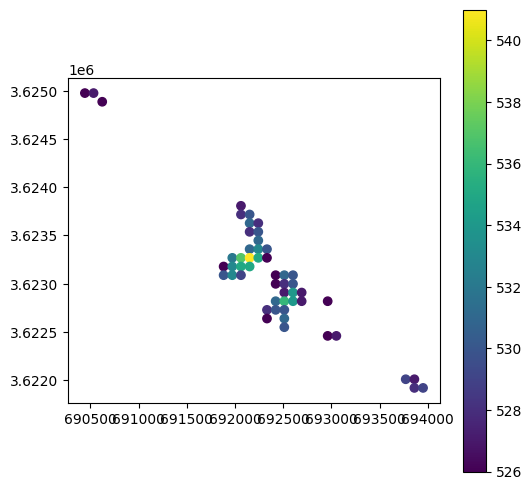

In [76]:
import numpy as np
import rasterio
import shapely
import rasterstats
import geopandas as gpd
# Prepare raster
src = rasterio.open('output/carmel.tif')
r = src.read(1)
r1 = r.copy()
r1[r > 525] = np.arange(0, r[r > 525].size)
# Raster to polygons
shapes = rasterio.features.shapes(r1, mask=r > 525, transform=src.transform)
pol = list(shapes)
geom = [shapely.geometry.shape(i[0]) for i in pol]
geom = gpd.GeoSeries(geom, crs=src.crs)
# Polygons to points
geom = geom.centroid
result = gpd.GeoDataFrame(geometry=geom)
# Extract values to points
x = rasterstats.point_query(
    result, 
    r, 
    nodata = src.nodata, 
    affine = src.transform,
    interpolate='nearest'
)
result['elev'] = x
# Plot
result.plot(column='elev', legend=True);

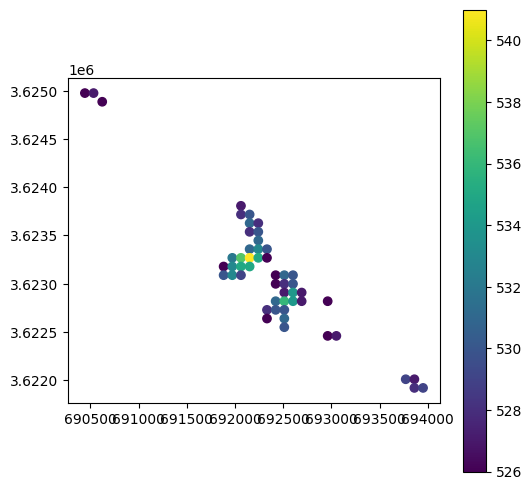

In [ ]:
plot = result.plot(column='elev', legend=True);
fig = plot.get_figure()
glue('exercise-11-f', fig, display=False)

### Exercise 11-g

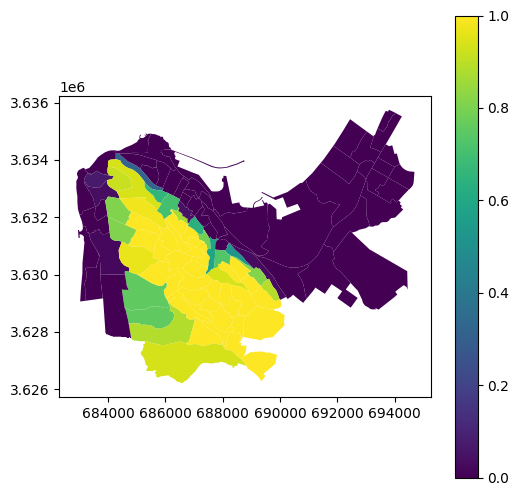

In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
# Prepare raster
src = rasterio.open('output/carmel.tif')
r = src.read(1)
r[(r != -9999) & (r < 100)] = 0
r[r >= 100] = 1
# Prepare polygons
stat = gpd.read_file('data/statisticalareas_demography2019.gdb')
stat = stat[['SHEM_YISHUV', 'STAT11', 'geometry']]
sel = stat['SHEM_YISHUV'] == 'חיפה'
stat = stat[sel]
stat = stat.reset_index(drop = True)
stat = stat.to_crs(src.crs)
# Extract
result = zonal_stats(stat, r, nodata=-9999, affine=src.transform, stats='mean')
result = pd.DataFrame(result)
stat1 = pd.concat([stat, result], axis=1)
# Plot
stat1.plot(column="mean", legend=True);

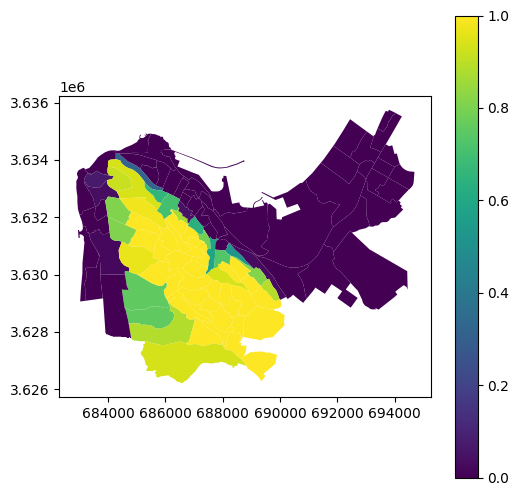

In [79]:
plot = stat1.plot(column="mean", legend=True);
fig = plot.get_figure()
glue("exercise-11-g", fig, display=False)

### Exercise 11-h

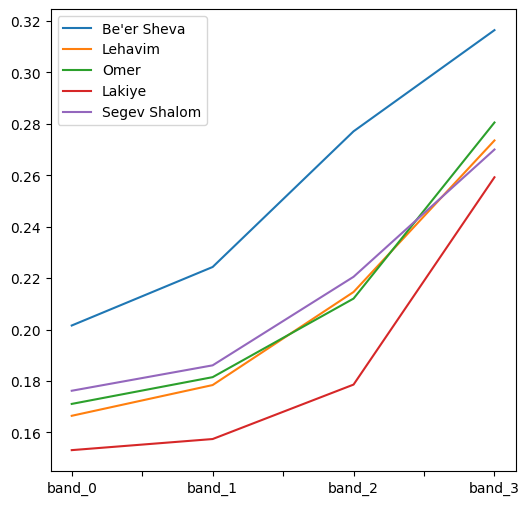

In [80]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
# Prepare raster
src = rasterio.open('output/sentinel2.tif')
r = src.read()
r = r / 10000
# Prepare polygons
pol = gpd.read_file('data/muni_il.shp')
pol = pol[['Muni_Eng', 'geometry']]
sel = ["Be'er Sheva", "Lehavim", "Omer", "Lakiye", "Segev Shalom"]
pol = pol[pol["Muni_Eng"].isin(sel)]
pol = pol.to_crs(src.crs)
# Extract
result = []
for band in range(r.shape[0]):
    tmp = zonal_stats(pol, r[band], nodata=-9999, affine=src.transform, stats='mean')
    tmp = pd.DataFrame(tmp)
    tmp = tmp.rename(columns = {'mean': 'band_' + str(band)})
    tmp.index = sel
    result.append(tmp)
result = pd.concat(result, axis=1)
# Plot
result.T.plot();

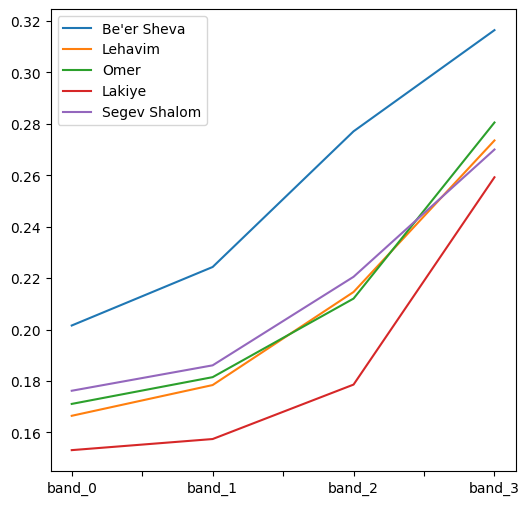

In [81]:
plot = result.T.plot();
fig = plot.get_figure()
glue('exercise-11-h', fig, display=False)